In [2]:
import requests
import pendulum
from pathlib import Path
import os
import sys

In [10]:
"""
Caso não exista a pasta 'downloads', ela é criada ao chamar este módulo
"""
#caminho_base = utils.dir_abs
diretorio_saida = Path(f'download/')
diretorio_saida.mkdir(exist_ok=True, parents=True)


def auxiliar_download(url_base:str, data_requerida:pendulum.datetime, nome_arquivo:str) -> bool:
    """ Subfunção de download(). Não é chamada diretamente.
    Faz a requisição do dado de TSM no repositório da NOAA.
    Args:
        url_base (str): Parte imutável do link de endereço.
        data_requerida (pendulum.datetime): data do dado procurado.
        nome_arquivo (str): [description] Nome do arquivo a ser requisitado.
    Returns:
        bool: True = dado baixado, False= erro 404 | arquivo não disponível.
    """

    url=f'{url_base}/{nome_arquivo}'
    resp=requests.get(url)

    if resp.status_code == 200:
        resp=requests.get(url).content
        diretorio = Path(diretorio_saida, nome_arquivo)

        with open(diretorio, "wb") as arquivo_:
            arquivo_.write(resp)
            print(f"{nome_arquivo} [ok]")
            mensagem_de_sucesso = True

    elif resp.status_code == 404:
        print(f'Erro 404. {nome_arquivo} ainda não disponível')
        mensagem_de_sucesso = False

    return mensagem_de_sucesso


def download(data_string:str=None, hoje:bool=False) -> str:
    """Chama a função de download dos dados de temperatura oceânica do NOAA.
    Caso o dado final não esteja pronto, baixa o preliminar.
    Args:
        data_string (str, optional): [DD-MM-YYYY] data do dado procurado. Defaults to None.
        hoje (bool, optional): Habilita o dia atual na hora da execução. Sobrescreve o data_string. Defaults to False.
    Returns:
        str: Nome do arquivo baixado
    """

    data_requerida = pendulum.now('America/Sao_Paulo') if hoje else pendulum.from_format(data_string, 'DD-MM-YYYY')
    #url_base = 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr'
    #url_base='https://ftp.emc.ncep.noaa.gov/cmb/sst/oimonth_v2/GRIB'
    url_base='https://ftp.cpc.ncep.noaa.gov/precip/PORT/sst/oimonth_v2/GRIB/'

    nome_arquivo = f'oiv2mon.{data_requerida.format("YYYYMM")}.grb'	
    sucesso = auxiliar_download(url_base, data_requerida, nome_arquivo)
    print(f'{nome_arquivo} {sucesso}')
    '''
    if sucesso:
        tipo = "consistido"
        return nome_arquivo, tipo
    else :
        nome_arquivo =  f'oiv2mon.{data_requerida.format("YYYYMM")}198111.grb'	
        sucesso = auxiliar_download(url_base, data_requerida, nome_arquivo)
        
        if sucesso:
            tipo = "preliminar"
            return nome_arquivo, tipo
        else:
            sys.exit('A data solicitada ainda não possui dados')
    '''

In [11]:
#import tsm
import pendulum

inicio = pendulum.datetime(2020,9,1)    #(1991, 1, 1)
fim = pendulum.datetime(2020, 12, 31)
periodo = pendulum.period(inicio, fim)

for dt in periodo.range('months'):
    data_string = dt.format('DD-MM-YYYY')

    download(data_string=data_string)

oiv2mon.202009.grb [ok]
oiv2mon.202009.grb True
oiv2mon.202010.grb [ok]
oiv2mon.202010.grb True
oiv2mon.202011.grb [ok]
oiv2mon.202011.grb True
oiv2mon.202012.grb [ok]
oiv2mon.202012.grb True


In [12]:
import xarray as xr

In [15]:
ds = xr.open_dataset('download/oiv2mon.202012.grb')

In [16]:
ds

<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float64 -0.5 0.5 1.5 2.5 ... 355.5 356.5 357.5 358.5
    valid_time  datetime64[ns] ...
Data variables:
    t           (latitude, longitude) float32 ...
    p3091       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-09-20T10:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
dataset = xr.open_mfdataset('download/*.grb', concat_dim="valid_time", combine="nested",
                data_vars='minimal', coords='minimal', compat='override',
                backend_kwargs={
                    "filter_by_keys": {
                        "typeOfLevel": "surface",
                        "shortName": "t",
                    },
                 },
                parallel=True)

In [22]:
dataset

<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360, valid_time: 360)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float64 -0.5 0.5 1.5 2.5 ... 355.5 356.5 357.5 358.5
  * valid_time  (valid_time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
Data variables:
    t           (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-09-20T10:39 GRIB to CDM+CF via cfgrib-0.9.1...

In [23]:
clima_tsm = dataset.t.groupby('valid_time.month').mean()

In [24]:
clima_tsm

<xarray.DataArray 't' (month: 12, latitude: 180, longitude: 360)>
dask.array<stack, shape=(12, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] ...
    step       timedelta64[ns] ...
    surface    float64 ...
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float64 -0.5 0.5 1.5 2.5 ... 355.5 356.5 357.5 358.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [26]:
clima_tsm.to_netcdf('oisst_climatologia_1991-2020.nc')

In [27]:
import recorta_dado
import pandas as pd

In [43]:
dicionario = {
            'mes'   : [1,2,3,4,5,6,7,8,9,10,11,12],
            'nino34': [],
}

latitude=(5, -5)
longitude=(-170, -120)

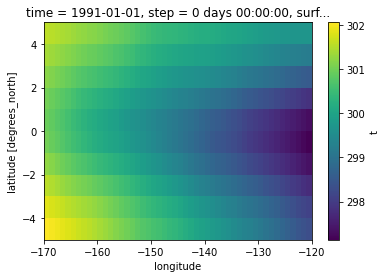

In [47]:
tsm_nino.plot()

In [44]:
for mes in range(1,12+1):
    tsm = clima_tsm.sel(month=mes)
    
    #for regiao in regioes.keys():

    tsm_nino = recorta_dado.main(tsm,
        contorno_tipo='lat_lon',
        tipo='grib',
        latitude=[ latitude[0], latitude[1] ], 
        longitude=[ longitude[0], longitude[1] ]
        )

    valor = tsm_nino.mean(dim=["latitude", "longitude"]) 
    valor = valor
    valor = round(float(valor.values), 2)
    
    dicionario['nino34'].append(valor)

    print(f'O valor da região nino34 no mês {mes} é : {valor}')

O valor da região nino34 no mês 1 é : 299.66
O valor da região nino34 no mês 2 é : 299.85
O valor da região nino34 no mês 3 é : 300.41
O valor da região nino34 no mês 4 é : 301.02
O valor da região nino34 no mês 5 é : 301.07
O valor da região nino34 no mês 6 é : 300.87
O valor da região nino34 no mês 7 é : 300.42
O valor da região nino34 no mês 8 é : 299.95
O valor da região nino34 no mês 9 é : 299.79
O valor da região nino34 no mês 10 é : 299.8
O valor da região nino34 no mês 11 é : 299.83
O valor da região nino34 no mês 12 é : 299.73


In [49]:
dt = pd.DataFrame.from_dict(dicionario)

In [53]:
dt.set_index('mes').to_csv('clima_nino34.csv', sep=';')